<a href="https://colab.research.google.com/github/davrodrod/algoritmosIA/blob/master/David_Rodriguez_Rodrigo_Caso_Grupal_Convolutional_Neural_Networks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 2: Convolutional Neural Networks

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import keras
import matplotlib.pyplot as plt
import glob
import time
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import History
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split #Esto finalmente no se usa
from tensorflow.keras.models import load_model
from keras.callbacks import CSVLogger
from tensorflow.keras import regularizers

In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10665984/10658925 [==============================] - 2s 0us/step


In [ ]:
#Funciones útiles

# Se crea está función para comparar losses en hasta 5 modelos diferentes
def plot_compare_multiple_losses(history, name, title="Graph title"):
    """Compara losses de hasta 5 entrenamientos"""
    color = ["green", "blue", "red", "orange", "yellow"]
    legend = []
    for i in range(0,min(len(history),5)):
      plt.plot(history[i].history['loss'], color=color[i])
      plt.plot(history[i].history['val_loss'], 'r--', color=color[i])
      legend.append('Train ' + name[i])
      legend.append('Val ' + name[i])

    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(legend,
               loc='upper right')
    plt.show()

# Se crea está función para comparar accuracies en hasta 5 modelos diferentes
def plot_compare_multiple_accs(history, name, title="Graph title"):
    """Compara losses de hasta 5 entrenamientos"""
    color = ["green", "blue", "red", "orange", "yellow"]
    legend = []
    for i in range(0,min(len(history),5)):
      plt.plot(history[i].history['accuracy'], color=color[i])
      plt.plot(history[i].history['val_accuracy'], 'r--', color=color[i])
      legend.append('Train ' + name[i])
      legend.append('Val ' + name[i])

    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(legend,loc='lower right')
    plt.show()

rutaPesos = "/content/drive/My Drive/SCA_Act2/"
def salvarPesos (modelo, nombre):
  nombreFicheroPesos = rutaPesos + "pesos" + str(nombre)
  modelo.save_weights(nombreFicheroPesos)

def recuperarPesos (modelo, nombre):
  nombreFicheroPesos = rutaPesos + "pesos" + str(nombre)
  modelo.load_weights(nombreFicheroPesos)
  return modelo

def visualize_example(x, label=None, figsize=(2,2)):
    plt.figure(figsize=figsize)
    x_invertido = np.fliplr(x.reshape(-1,3)).reshape(x.shape)
    plt.imshow(x_invertido)
    plt.ion()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label)
    plt.show()


In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True, color=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            if color==True:
              image = cv2.imread(os.path.join(dirname, character, image_name))
            else:
              image = cv2.imread(os.path.join(dirname, character, image_name),cv2.IMREAD_GRAYSCALE)
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True, color = True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            if color==True:
              image = cv2.imread(filename)
            else:
              image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS,color=True) #Datos de training
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS,color=True) #Datos de test

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Análisis de los datos a utilizar

Siempre es conveniente hacer un análisis previo de los datos que tenemos presentes en nuestro dataset. En este caso usamos la función shape
a modo de desvelar la estructura interna de los datos que hemos cargado previamente

In [ ]:
#Aplicamos la función shape para observar que tenemos en los datos de entrenamiento y de test.
print(X.shape)
print(X_t.shape)

#Si detallamos más los datos de entrenamiento obtenemos que tenemos obtenemos:
print("\nEn los datos de entrenamiento tenemos: "+str(X.shape[0])+" Imagenes con "+str(X.shape[1])+" pixeles por "+str(X.shape[2])+" lineas y "+str(X.shape[3])+" canales")

#Haciendo lo mismo para los datos de test nos queda:
print("\nEn los datos de test tenemos: "+str(X_t.shape[0])+" Imagenes con "+str(X_t.shape[1])+" pixeles por "+str(X_t.shape[2])+" lineas y "+str(X_t.shape[3])+" canales")


(18992, 64, 64, 3)
(890, 64, 64, 3)

En los datos de entrenamiento tenemos: 18992 Imagenes con 64 pixeles por 64 lineas y 3 canales

En los datos de test tenemos: 890 Imagenes con 64 pixeles por 64 lineas y 3 canales


Como podemos observar, tanto las imágenes de entrenamiento como las de test tienen un formato de 64 x 64 píxeles con 3 canales. Esto se debe a que la función de carga de imágenes aplica un resize a dicho tamaño para que todas las imágenes estén en el mismo formato y dimensiones.

Nuestros datos vienen por defecto sin normalizar, por lo cual para hacer más simples los cálculos y la eficiencia de los modelos que aplicaremos normalizamos la data presente tanto en los set de entrenamiento como en los de test diviendo entre 255 para poder obtener valores entre 0 y 1, y a la vez transformar el tipo de valores de integer a float:

In [ ]:
#Normalizamos nuestro conjunto de entrenamiento y de test diviendo ambos entre 255
X=X/255
X_t= X_t/255

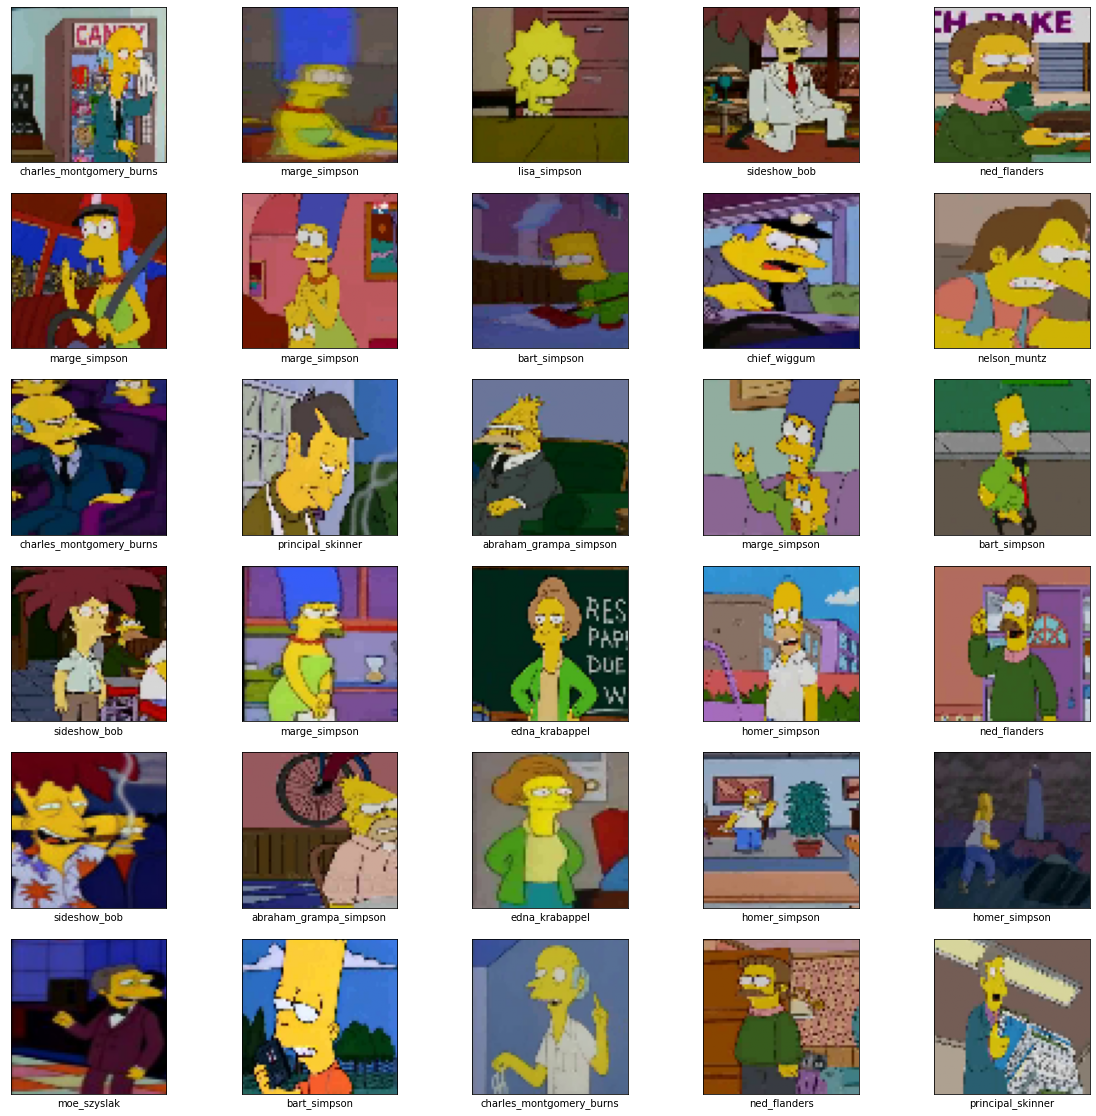

In [ ]:
# Se invierten los colores para ver las imágenes en rgb
plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if(X[i].ndim ==3):
      X_pintar = np.fliplr(X[i].reshape(-1,3)).reshape(X[i].shape)
      plt.imshow(X_pintar, cmap=plt.cm.binary)
    else:
      X_pintar = X[i]
      plt.imshow(X_pintar,cmap='gray')
    
    plt.xlabel(MAP_CHARACTERS[y[i]])
plt.show()

# Comparación de modelos CNNs con un modelo de Fully Connected

## Modelo CNN standard


In [ ]:
in_shape = X.shape[1:]
print(in_shape)
n_classes=len(MAP_CHARACTERS)

def build_model_standard():
  # definimos nuestro modelo 1 el cual usaremos como referencia
  model = Sequential()
  model.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape))
  model.add(MaxPool2D((3,3)))
  model.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape))
  model.add(MaxPool2D((3,3)))
  model.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape))
  model.add(MaxPool2D((3,3)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.summary()

  # define loss and optimizer
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


model_standard = build_model_standard()

inicio = time.time()

# fit the model
history_standard=model_standard.fit(X, y, validation_split=0.2, epochs=20, batch_size=128)

fin = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador Adam tarda ",fin - inicio," segundos en procesarse")


# evaluate the model
loss, acc = model_standard.evaluate(X_t, y_t, verbose=0)
print('Accuracy en Test: %.3f' % acc)
print("\nNuestro modelo con el optimizador Adam tarda ",fin - inicio," segundos en procesarse")

(64, 64, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)    

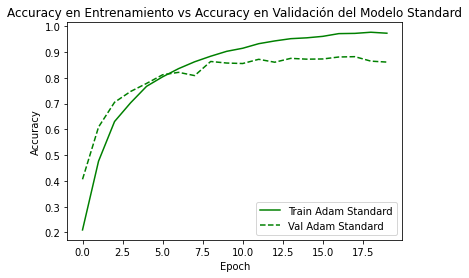

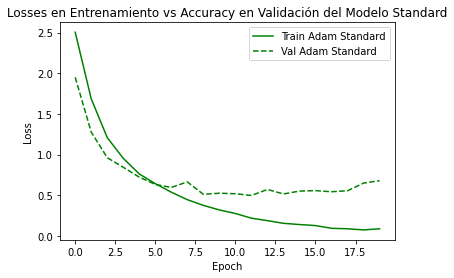

In [ ]:
#Imprimimos una gráfica de comparación del modelo llamando a la función que hemos creado
 
plot_compare_multiple_accs([history_standard],name=['Adam Standard'],title="Accuracy en Entrenamiento vs Accuracy en Validación del Modelo Standard")
plot_compare_multiple_losses([history_standard],name=['Adam Standard'],title="Losses en Entrenamiento vs Accuracy en Validación del Modelo Standard")

## Modelo Fully Connected

In [ ]:
def entrenarRedSecuencial(x_train, y_train, inputShape, 
                          optimizer = 'adam',
                          batchSize = 64, epochs = 20, 
                          validationSplit = 0.2):
  # Definición del modelo
  model = Sequential([
      Flatten(input_shape=inputShape),
      keras.layers.BatchNormalization(),
      Dense(512, activation='relu'),
      keras.layers.BatchNormalization(),
      # Añadimos capas dropout para mejorar entrenamiento evitando overfitting
      Dropout(0.3),
      Dense(512, activation='relu'),#128
      keras.layers.BatchNormalization(),
      Dropout(0.3),
      Dense(256, activation='relu'),
      keras.layers.BatchNormalization(),
      Dropout(0.3),
      Dense(18, activation='softmax')
  ])
  # Visualizamos el modelo:
  model.summary()
  # Medimos el tiempo de entrenamiento
  start = time.time()

  model.compile(optimizer=optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Método para no caer en overfitting
  earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=5)


  historyEnd = model.fit(x_train, y_train,
                  batch_size=batchSize, 
                  epochs=epochs,
                  validation_split=validationSplit, 
                  verbose=0,
                  callbacks=[earlyStopping])
      

  end = time.time()

  print("Time (in seconds):", end - start)
  print("La accuracy en entrenamiento es: ", 
        np.max(historyEnd.history['accuracy']))
  print("La accuracy en validación es: ", 
        np.max(historyEnd.history['val_accuracy']))
  print("La accuracy del modelo con los datos de test es: ",
        model.evaluate(X_t, y_t)[1])
  
  plot_compare_multiple_accs([historyEnd],["fully connected"],title="Gráfica Accuracy Fully Connected")
  plot_compare_multiple_losses([historyEnd],["fully connected"],title="Gráfica Loss Fully Connected")
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12288)             49152     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               6291968   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)              

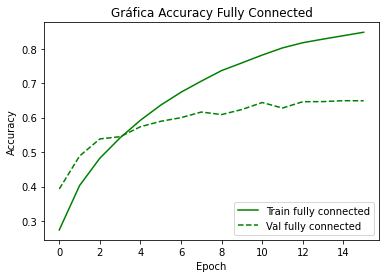

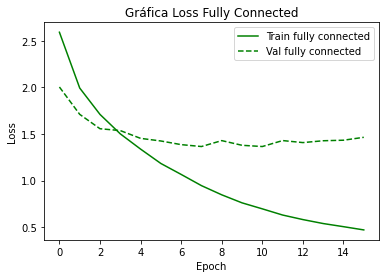

In [ ]:
# Entrnamiento red secuencial
model_fully_connected = entrenarRedSecuencial(X, y, (64,64,3), epochs = 35)

## Comparativa entre modelos

Una vez observados tanto los datos como los gráficos del entrenamiento, podemos sacar varias conclusiones:

* Parámetros: La red neuronal Fully connected necesita muchísimos más parámetros en comparación con la CNN (6,744,850 VS  501,650). La CNN en este caso necesita únicamente un 7,4% de los parámetros que requiere la otra red para llegar a unos resultados comparables.    

* Valores de accuracy y loss: Los valores obtenidos en ambos casos son bastante superiores en la CNN respecto a la Fully Connected.    

* Tiempos: Si bien es cierto que la CNN ha tardado unos segundos más en entrenar que el modelo Fully Connected, se puede explicar teniendo en cuenta que a este último se le ha añadido un early stopping que únicamente ha entrenado durante 13 epochs en lugar de 20, por lo que el tiempo por epoch es superior en la Fully Connected que en la CNN.

# Utilización de distintas arquitecturas CNNs

## Optimizadores

### Optimizador SGD

In [ ]:
#Probaremos distintos arquitecturas CNN con la intención de identificar diferencias y detectar posibles
#mejoras en los modelos a utilizar

#Probaremos nuestro mismo modelo 1 pero usaremos con el optimizador estocástico de gradiente descendiente SGD
def build_model_sgd():
  # definimos el modelo con el optimizador SGD
  model_sgd = Sequential()
  model_sgd.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape))
  model_sgd.add(MaxPool2D((3,3)))
  model_sgd.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape))
  model_sgd.add(MaxPool2D((3,3)))
  model_sgd.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape))
  model_sgd.add(MaxPool2D((3,3)))
  model_sgd.add(Flatten())
  model_sgd.add(Dense(256, activation='relu'))
  model_sgd.add(Dropout(0.5))
  model_sgd.add(Dense(n_classes, activation='softmax'))
  # definimos perdida y el optimizador SGD
  model_sgd.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_sgd

model_sgd = build_model_sgd()

inicio_sgd = time.time()
# hacemos fit del modelo
history_sgd=model_sgd.fit(X, y, validation_split=0.2, epochs=20, batch_size=128,verbose=0)
fin_sgd = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador SGD tarda ",fin_sgd - inicio_sgd," segundos en procesarse")

# evaluamos el modelo
loss, acc = model_sgd.evaluate(X_t, y_t, verbose=2)
print('Accuracy en Test: %.3f' % acc)


Nuestro modelo con el optimizador SGD tarda  50.81189250946045  segundos en procesarse
28/28 - 0s - loss: 1.7853 - accuracy: 0.4843
Accuracy en Test: 0.484


### Optimizador RMSprop

In [ ]:
#Probaremos nuestro mismo modelo pero usaremos con el optimizador RMSprop

def build_model_rmsprop():
  # definimos modelo RMSprop
  model_rmsprop = Sequential()
  model_rmsprop.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape))
  model_rmsprop.add(MaxPool2D((3,3)))
  model_rmsprop.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape))
  model_rmsprop.add(MaxPool2D((3,3)))
  model_rmsprop.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape))
  model_rmsprop.add(MaxPool2D((3,3)))
  model_rmsprop.add(Flatten())
  model_rmsprop.add(Dense(256, activation='relu'))
  model_rmsprop.add(Dropout(0.5))
  model_rmsprop.add(Dense(n_classes, activation='softmax'))
  # definimos perdida y el optimizador
  model_rmsprop.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_rmsprop

model_rmsprop = build_model_rmsprop()

inicio_rmsprop = time.time()
# fit the model
history_rmsprop=model_rmsprop.fit(X, y, validation_split=0.2, epochs=20, batch_size=128,verbose=0)
fin_rmsprop = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador RMSprop tarda ",fin_rmsprop - inicio_rmsprop," segundos en procesarse")

# evaluamos el modelo
loss, acc = model_rmsprop.evaluate(X_t, y_t)
print('Accuracy en Test: %.3f' % acc)



Nuestro modelo con el optimizador RMSprop tarda  52.11899518966675  segundos en procesarse
28/28 [==============================] - 0s 4ms/step - loss: 0.1471 - accuracy: 0.9730
Accuracy en Test: 0.973


### Comparativa de optimizadores

A continuación se muestra una comparativa de accuracies y pérdidas de los distintos modelos.

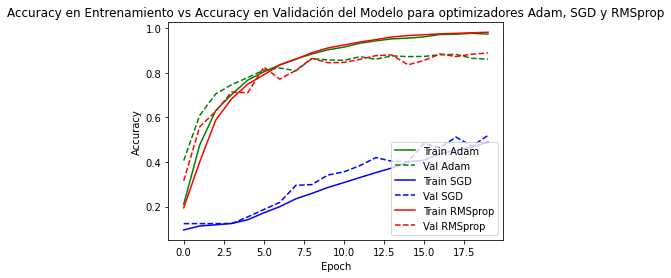

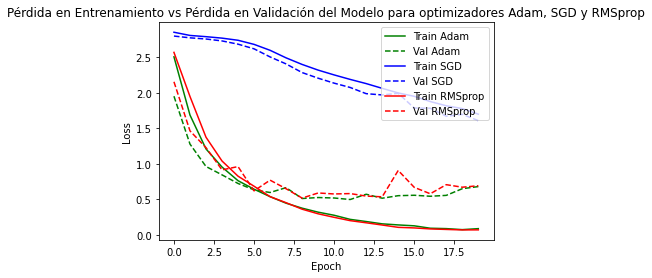

In [ ]:
#Usamos las funciones que creamos para dichos propósitos y observamos gráficamente para establecer comparaciones

plot_compare_multiple_accs([history_standard,history_sgd,history_rmsprop],name=['Adam','SGD','RMSprop'],title="Accuracy en Entrenamiento vs Accuracy en Validación del Modelo para optimizadores Adam, SGD y RMSprop")
plot_compare_multiple_losses([history_standard,history_sgd,history_rmsprop],name=['Adam','SGD','RMSprop'],title="Pérdida en Entrenamiento vs Pérdida en Validación del Modelo para optimizadores Adam, SGD y RMSprop")

Viendo las gráficas anteriores, podemos apreciar que de los optimizadores usados en los modelos para 20 epochs obtenemos un rendimiento bastante similar entre **Adam** y **RMSprop**, con un rendimiento bastante deficiente para el optimizador **SGD**. Tanto en accuracy como en pérdida tanto el optimizador **Adam** como **RMSprop** dan resultados cercanos.

En cuanto a los tiempos de ejecución vemos que el modelo que más rápido se ejecutó fue el **SGD** con 45.97 segundos, seguido del **RMSprop** con 47.61 segundos y por último el **Adam** con 52.04 segundos, por lo cual no se descarta que para mayor cantidad de epochs el rendimiento de **RMSprop** sea mejor que el de **Adam**.

## Profundidad


### Modelo Adam con una capa extra

In [ ]:
#Procederemos a usar el modelo 1  con el optimizador Adam añadiendo 1 capa adicional de 8 neuronas al inicio

def build_model_cp():
  # definimos el modelo
  model_cp = Sequential()
  model_cp.add(Conv2D(8, (1,7), activation='relu', input_shape=in_shape))# capa nueva
  model_cp.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape))
  model_cp.add(MaxPool2D((3,3)))
  model_cp.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape))
  model_cp.add(MaxPool2D((3,3)))
  model_cp.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape))
  model_cp.add(MaxPool2D((3,3)))
  model_cp.add(Flatten())
  model_cp.add(Dense(256, activation='relu'))
  model_cp.add(Dropout(0.5))
  model_cp.add(Dense(n_classes, activation='softmax'))
  # definimos pérdida y optimizador
  model_cp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_cp

model_cp = build_model_cp()
inicio_cp = time.time()
# Hacemos fit del modelo
history_cp=model_cp.fit(X, y, validation_split=0.2, epochs=20, batch_size=128,verbose=0)
fin_cp = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo cambiando la profundidad de la red tarda ",fin_cp - inicio_cp," segundos en procesarse")

# evaluamos el modelo
loss, acc = model_cp.evaluate(X_t, y_t, verbose=2)
print('Accuracy en Test: %.3f' %acc)


Nuestro modelo cambiando la profundidad de la red tarda  72.88933038711548  segundos en procesarse
28/28 - 0s - loss: 0.0761 - accuracy: 0.9809
Accuracy en Test: 0.981


En comparación con nuestro modelo de referencia podemos observar que mejoramos ligeramente el performance en accuracy en validación y disminuimos apenas la pérdida en el mismo segmento incorporando 24 segundos adicionales de procesamiento para el modelo en cuestión.

## Cambio de Hiperparámetros y regulador L2

### Modelo Regulador L2

In [ ]:
#Incorporarmos variables aleatorias normales tanto de input como de kernel en todas las capas donde tengamos activaciones

def build_model_hip_l2():
  # definimos nuestro modelo 5 el cual usaremos como referencia
  model_hip_l2 = Sequential()
  model_hip_l2.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape,kernel_initializer='random_normal',bias_initializer='random_normal',kernel_regularizer='l2'))
  model_hip_l2.add(MaxPool2D((3,3)))
  model_hip_l2.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape,kernel_initializer='random_normal',bias_initializer='random_normal',kernel_regularizer='l2'))
  model_hip_l2.add(MaxPool2D((3,3)))
  model_hip_l2.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape,kernel_initializer='random_normal',bias_initializer='random_normal',kernel_regularizer='l2'))
  model_hip_l2.add(MaxPool2D((3,3)))
  model_hip_l2.add(Flatten())
  model_hip_l2.add(Dense(256, activation='relu',kernel_initializer='random_normal',bias_initializer='random_normal', kernel_regularizer='l2'))
  model_hip_l2.add(Dropout(0.5))
  model_hip_l2.add(Dense(n_classes, activation='softmax',kernel_initializer='random_normal',bias_initializer='random_normal', kernel_regularizer='l2'))
  # definimos pérdida y el optimizador
  model_hip_l2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_hip_l2

model_hip_l2 = build_model_hip_l2()
inicio_hip_l2 = time.time()

# Hacemos fit en el modleo
history_hip_l2=model_hip_l2.fit(X, y, validation_split=0.2, epochs=20, batch_size=128,verbose=0)
fin_hip_l2 = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador con inicializadores de variable aleatoria normal y regularizador L2 tarda ",fin_hip_l2 - inicio_hip_l2," segundos en procesarse")   

# evaluamos el modelo
loss, acc = model_hip_l2.evaluate(X_t, y_t, verbose=0)
print('Accuracy en Test: %.3f' % acc)



Nuestro modelo con el optimizador con inicializadores de variable aleatoria normal y regularizador L2 tarda  50.8352472782135  segundos en procesarse
Accuracy en Test: 0.643


No se observan mejoras en el modelo usando iniciación de variables a través de una variable aleatoria normal ni usando un regulador de tipo L2. Comparado con nuestro modelo original vemos que no hemos obtenido mejoras sino más bien hemos perdido accuracy y aumentado la pérdida utilizando esta arquitectura

## Batch Normalization con RMSprop

In [ ]:
def build_model_rmspropbn():
  # definimos nuestro modelo 1 el cual usaremos como referencia y agregamos una capa adicional de 8 neuronas con un kernel_size (1,7)
  model_rmspropbn = Sequential()
  model_rmspropbn.add(BatchNormalization())
  model_rmspropbn.add(Conv2D(64, (5,5), activation='relu', input_shape=in_shape))
  model_rmspropbn.add(BatchNormalization())
  model_rmspropbn.add(MaxPool2D((3,3)))
  model_rmspropbn.add(Conv2D(128, (4,4), activation='relu', input_shape=in_shape))
  model_rmspropbn.add(BatchNormalization())
  model_rmspropbn.add(MaxPool2D((3,3)))
  model_rmspropbn.add(Conv2D(256, (3,3), activation='relu', input_shape=in_shape))
  model_rmspropbn.add(BatchNormalization())
  model_rmspropbn.add(MaxPool2D((3,3)))
  model_rmspropbn.add(Flatten())
  model_rmspropbn.add(Dense(256, activation='relu'))
  model_rmspropbn.add(Dropout(0.5))
  model_rmspropbn.add(Dense(n_classes, activation='softmax'))
  # definimos pérdida y el optimizador RMSprop
  model_rmspropbn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model_rmspropbn

model_rmspropbn = build_model_rmspropbn()

inicio_rmspropbn = time.time()
# Hacemos fit en el modleo
history_rmspropbn=model_rmspropbn.fit(X, y, validation_split=0.2, epochs=20, batch_size=128,verbose=0)
fin_rmspropbn = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador con RMSprop y Batch Normalization tarda ",fin_rmspropbn - inicio_rmspropbn," segundos en procesarse")

# evaluate the model
loss, acc = model_rmspropbn.evaluate(X_t, y_t, verbose=0)
print('Accuracy en Test: %.3f' % acc)


Nuestro modelo con el optimizador con RMSprop y Batch Normalization tarda  74.96986365318298  segundos en procesarse
Accuracy en Test: 0.955


### Comparativa de arquitecturas


A continuación se muestra una comparativa de los resultados obtenidos utilizazndo diversos tipos de arquitecturas.

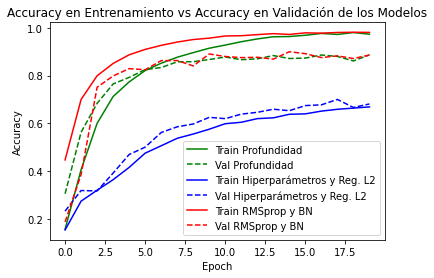

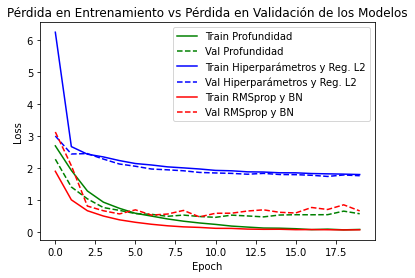

In [ ]:
plot_compare_multiple_accs([history_cp,history_hip_l2,history_rmspropbn],name=['Profundidad','Hiperparámetros y Reg. L2','RMSprop y BN'],title="Accuracy en Entrenamiento vs Accuracy en Validación de los Modelos")
plot_compare_multiple_losses([history_cp,history_hip_l2,history_rmspropbn],name=['Profundidad','Hiperparámetros y Reg. L2','RMSprop y BN'],title="Pérdida en Entrenamiento vs Pérdida en Validación de los Modelos")


Al ver la gráfica anterior podemos observar que los mejores resultados en nuestro caso vienen dados al añadir una capa convolucional 2D de 8 neuronas al inicio de nuestro modelo utilizando el optimizador Adam ( Color Verde en la gráfica) y añadiendo un Kernel Size de (1,7). Adicionalmente vemos que empleando el optimizador RMSprop y Batch Normalization obtenemos resultados casi iguales en entrenamiento que los obtenidos añadiendo mayor profundidad al modelo, pero con una pérdida un poco mayor en validación y un accuracy ligeramente más alto también en este segmento. También podemos decir que al variar hiperparámetros ( En este caso inicializamos con una variable aleatoria normal) y usar un regularizador de tipo L2, los resultados son poco eficientes tanto en training como en validación con gran cantidad de pérdida.

En cuanto a los tiempos de ejecución, podemos observar que el mejor modelo en ser procesado fue el modelo que sufre cambios en los hiperparámetros con 48,51 segundos, seguido del modelo que cambia la profundidad en la arquitectura con 69,49 segundos y vemos que el modelo que más demora en procesarse es el modelo que aplica el optimizador RMSProp junto a Batch Normalization con 71.05 segundos

# Utilización de data augmentation

(64, 64, 3)

Nuestro modelo con el optimizador Adam tarda  764.0929923057556  segundos en procesarse


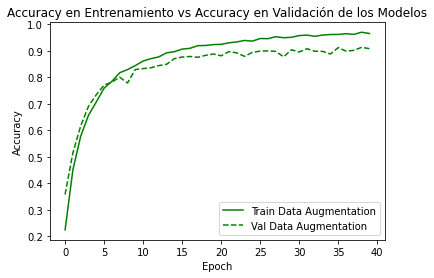

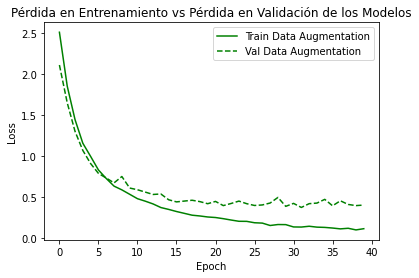

Accuracy en Test: 0.975


In [ ]:
in_shape = X.shape[1:]
n_classes=len(MAP_CHARACTERS)
print(in_shape)
inicio = time.time()
image_generator = ImageDataGenerator(validation_split=0.2,
                                     #rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True
                                     )
image_generator.fit(X)

train_dataset = image_generator.flow(X,
                                     y,
                                     batch_size=256,
                                     subset="training")

validation_dataset = image_generator.flow(X,
                                     y,
                                     batch_size=256,
                                     subset="validation")

def build_model_data_augmentation():
  do=0
  model = Sequential()
  model.add(Conv2D(64, (2,2), activation='relu', input_shape=in_shape))
  model.add(Conv2D(64, (2,2), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(128, (2,2), activation='relu'))
  model.add(Conv2D(128, (2,2), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(256, (2,2), activation='relu'))
  model.add(Conv2D(256, (2,2), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_classes, activation='softmax'))

  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model_data_augmentation = build_model_data_augmentation()

inicio = time.time()
# fit the model
history_data_augmentation=model_data_augmentation.fit(train_dataset,
              validation_data=validation_dataset, 
              batch_size=1024,
              verbose=0, 
              epochs=40)
fin = time.time() #Nos servirá para saber cuanto tarda en procesarse nuestro modelo
print("\nNuestro modelo con el optimizador Adam tarda ",fin - inicio," segundos en procesarse")

plot_compare_multiple_accs([history_data_augmentation],name=['Data Augmentation'],title="Accuracy en Entrenamiento vs Accuracy en Validación de los Modelos")
plot_compare_multiple_losses([history_data_augmentation],name=['Data Augmentation'],title="Pérdida en Entrenamiento vs Pérdida en Validación de los Modelos")

# evaluate the model
loss, acc = model_data_augmentation.evaluate(X_t, y_t, verbose=0)
print('Accuracy en Test: %.3f' % acc)

Como se pueded observar en las gráficas, no se requiere aplicar regularización porque no hay overfitting o éste es muy pequeño. El propio data augmentation es la regularización. 
Se alcanza accuracy en validación en torno al 90% y en test se supera el 97%.

Hay que hacer notar que al estamos apliacando data augmentation y luego dividimos los datasets de train y validación, por lo que las imágenes de validación también están "aumentadas". También se podrían haber dividido previamente los datos de entrenamiento en training y validación y luego aplicar data augmentation solo al training.

Puede observarse que al hacer data augmentation la red tarda más en converger, debido a que tiene que ajustarse a una cantidad mayor de imágenes.

# Análisis de resultados

## Realización de predicciones con el modelo



Como se ha podido observar, la mayoria de los modelos entrenados producen buenas predicciones.
A continuación se muestra el procedimiento para realizar predicciones teniendo una imagen como entrada.

Muestra: 829
[[1.6707164e-08 5.0100990e-09 6.3076214e-07 2.7266600e-05 9.3627954e-05
  9.9856722e-01 2.0476432e-06 6.5853033e-06 2.7917253e-07 9.4628030e-07
  4.5969490e-08 2.6973808e-08 5.2884579e-06 9.4596774e-04 2.2142729e-08
  3.7837555e-05 3.1146937e-04 4.8040295e-07]]
Clase predicha=5-comic_book_guy
Clase original=5-comic_book_guy


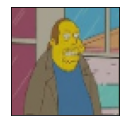

In [ ]:
# Realizar una predicción. Selecciono una imágen aleatoriamante
n_muestra= np.random.randint(X_t.shape[0])

print("Muestra: " + str(n_muestra))
image = X_t[n_muestra:n_muestra+1,:,:,:]
predict = model_standard.predict(image)
print(predict)
print('Clase predicha=' + str(argmax(predict)) + "-" + MAP_CHARACTERS[argmax(predict)])
print('Clase original=' + str(y_t[n_muestra]) +  "-" + MAP_CHARACTERS[y_t[n_muestra]])
visualize_example(X_t[n_muestra,:,:])

## Obtención de métricas de precisión y recall por clase

A continuación realizaremos un análisis de los resultados obtenidos por la primera CNN con optimizador adam y la CNN con data augmentation mediante el uso de diferentes métricas de evaluación y compararemos los resultados entre estas.

### Análisis modelo CNN adam

Análisis para el modelo standard:

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.92      0.96        48
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
            bart_simpson       0.94      0.92      0.93        50
charles_montgomery_burns       0.95      0.88      0.91        48
            chief_wiggum       0.96      1.00      0.98        50
          comic_book_guy       1.00      0.98      0.99        49
          edna_krabappel       1.00      0.94      0.97        50
           homer_simpson       0.96      0.98      0.97        50
           kent_brockman       0.98      0.96      0.97        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.94      0.92      0.93        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       0.98      1.00      0.99        49
             moe_s

abraham_grampa_simpson    1.000000
comic_book_guy            1.000000
ned_flanders              1.000000
edna_krabappel            1.000000
krusty_the_clown          1.000000
sideshow_bob              1.000000
marge_simpson             0.980392
milhouse_van_houten       0.980000
Name: precision, dtype: float64


Top 8 clases con mejor recall:


krusty_the_clown          1.00
apu_nahasapeemapetilon    1.00
moe_szyslak               1.00
milhouse_van_houten       1.00
marge_simpson             1.00
sideshow_bob              1.00
chief_wiggum              1.00
homer_simpson             0.98
Name: recall, dtype: float64


Top 8 clases con mejor f1-score:


krusty_the_clown          1.000000
sideshow_bob              1.000000
marge_simpson             0.990099
milhouse_van_houten       0.989899
comic_book_guy            0.989691
chief_wiggum              0.980392
apu_nahasapeemapetilon    0.980392
ned_flanders              0.979167
Name: f1-score, dtype: float64


Top 8 clases con peor precision:


moe_szyslak                 0.877193
bart_simpson                0.938776
lisa_simpson                0.938776
nelson_muntz                0.942308
charles_montgomery_burns    0.954545
homer_simpson               0.960784
principal_skinner           0.960784
apu_nahasapeemapetilon      0.961538
Name: precision, dtype: float64


Top 8 clases con peor recall:


charles_montgomery_burns    0.875000
abraham_grampa_simpson      0.916667
bart_simpson                0.920000
lisa_simpson                0.920000
edna_krabappel              0.940000
ned_flanders                0.959184
kent_brockman               0.960000
comic_book_guy              0.979592
Name: recall, dtype: float64


Top 8 clases con peor f1-score:


charles_montgomery_burns    0.913043
bart_simpson                0.929293
lisa_simpson                0.929293
moe_szyslak                 0.934579
abraham_grampa_simpson      0.956522
nelson_muntz                0.960784
edna_krabappel              0.969072
kent_brockman               0.969697
Name: f1-score, dtype: float64


Confusion Matrix


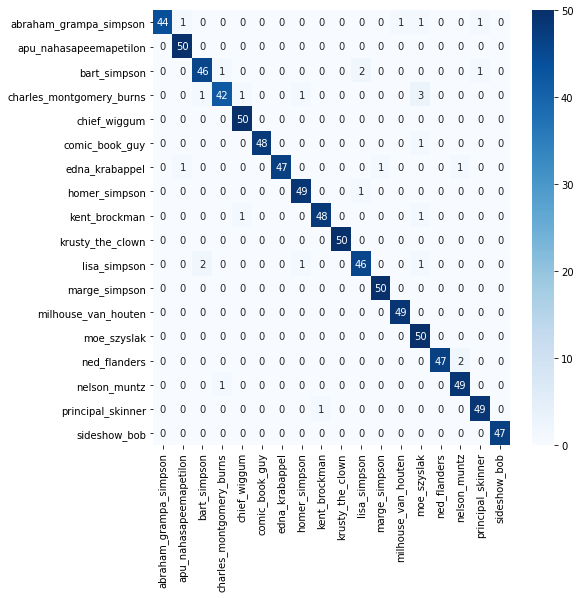

In [ ]:
batch_size = 32
#Confusion Matrix and Classification Report
Y_pred_standard = model_standard.predict(X_t, X_t.shape[0] // batch_size+1)
y_pred_standard = np.argmax(Y_pred_standard, axis=1)

def analisisPrecisionRecall(y_t,y_pred, dict_caracteres):
  print('\nClassification Report')
  target_names = ['Cats', 'Dogs', 'Horse']
  print(classification_report(y_t, y_pred, target_names=dict_caracteres.values()))
  cr_as_dict = classification_report(y_t,
                                     y_pred,
                                     target_names=dict_caracteres.values(),
                                     output_dict=True)
  cr_as_pd = pd.DataFrame(cr_as_dict)
  num_clases_top=8

  print("\nTop " + str(num_clases_top) + " clases con mejor precision:")
  display(cr_as_pd.T[0:18].sort_values('precision', ascending=False)['precision'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con mejor recall:")
  display(cr_as_pd.T[0:18].sort_values('recall', ascending=False)['recall'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con mejor f1-score:")
  display(cr_as_pd.T[0:18].sort_values('f1-score', ascending=False)['f1-score'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor precision:")
  display(cr_as_pd.T[0:18].sort_values('precision', ascending=True)['precision'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor recall:")
  display(cr_as_pd.T[0:18].sort_values('recall', ascending=True)['recall'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor f1-score:")
  display(cr_as_pd.T[0:18].sort_values('f1-score', ascending=True)['f1-score'].head(num_clases_top))

def analisisMatrizConfusion(y_t, y_pred, dict_caracteres):

  print('\nConfusion Matrix')
  cm = pd.DataFrame(confusion_matrix(y_t, y_pred),
                    columns=dict_caracteres.values(),
                    index=dict_caracteres.values())
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(data=cm,
              annot=True,
              ax=ax,
              cmap=plt.cm.Blues)
  

print("Análisis para el modelo standard:")
analisisPrecisionRecall(y_t,y_pred_standard,MAP_CHARACTERS)
analisisMatrizConfusion(y_t,y_pred_standard,MAP_CHARACTERS)

### Análisis modelo CNN con data augmentation

Análisis para el modelo con data augmentation:

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.96      0.98        48
  apu_nahasapeemapetilon       0.94      0.98      0.96        50
            bart_simpson       0.96      0.90      0.93        50
charles_montgomery_burns       0.92      0.96      0.94        48
            chief_wiggum       1.00      0.96      0.98        50
          comic_book_guy       0.98      1.00      0.99        49
          edna_krabappel       1.00      0.94      0.97        50
           homer_simpson       0.96      1.00      0.98        50
           kent_brockman       0.98      1.00      0.99        50
        krusty_the_clown       0.96      1.00      0.98        50
            lisa_simpson       0.96      0.94      0.95        50
           marge_simpson       1.00      0.96      0.98        50
     milhouse_van_houten       1.00      0.98      0.99        49
     

abraham_grampa_simpson    1.000000
edna_krabappel            1.000000
ned_flanders              1.000000
milhouse_van_houten       1.000000
marge_simpson             1.000000
sideshow_bob              1.000000
chief_wiggum              1.000000
kent_brockman             0.980392
Name: precision, dtype: float64


Top 8 clases con mejor recall:


krusty_the_clown     1.0
homer_simpson        1.0
principal_skinner    1.0
nelson_muntz         1.0
moe_szyslak          1.0
kent_brockman        1.0
sideshow_bob         1.0
comic_book_guy       1.0
Name: recall, dtype: float64


Top 8 clases con mejor f1-score:


sideshow_bob           1.000000
kent_brockman          0.990099
nelson_muntz           0.990099
comic_book_guy         0.989899
ned_flanders           0.989691
milhouse_van_houten    0.989691
principal_skinner      0.980392
moe_szyslak            0.980392
Name: f1-score, dtype: float64


Top 8 clases con peor precision:


charles_montgomery_burns    0.920000
apu_nahasapeemapetilon      0.942308
bart_simpson                0.957447
lisa_simpson                0.959184
homer_simpson               0.961538
principal_skinner           0.961538
krusty_the_clown            0.961538
moe_szyslak                 0.961538
Name: precision, dtype: float64


Top 8 clases con peor recall:


bart_simpson                0.900000
edna_krabappel              0.940000
lisa_simpson                0.940000
abraham_grampa_simpson      0.958333
charles_montgomery_burns    0.958333
chief_wiggum                0.960000
marge_simpson               0.960000
ned_flanders                0.979592
Name: recall, dtype: float64


Top 8 clases con peor f1-score:


bart_simpson                0.927835
charles_montgomery_burns    0.938776
lisa_simpson                0.949495
apu_nahasapeemapetilon      0.960784
edna_krabappel              0.969072
abraham_grampa_simpson      0.978723
chief_wiggum                0.979592
marge_simpson               0.979592
Name: f1-score, dtype: float64


Confusion Matrix


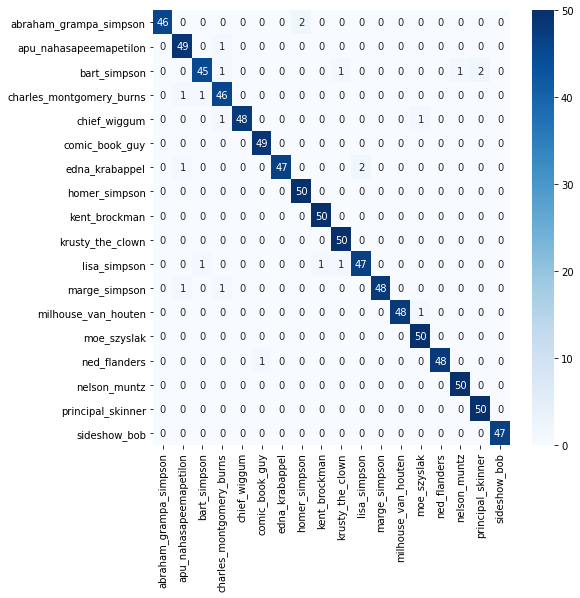

In [ ]:
batch_size = 32
#Confusion Matrix and Classification Report
Y_pred_data_augmentation = model_data_augmentation.predict(X_t, X_t.shape[0] // batch_size+1)
y_pred_data_augmentation = np.argmax(Y_pred_data_augmentation, axis=1)

def analisisPrecisionRecall(y_t,y_pred, dict_caracteres):
  print('\nClassification Report')
  target_names = ['Cats', 'Dogs', 'Horse']
  print(classification_report(y_t, y_pred, target_names=dict_caracteres.values()))
  cr_as_dict = classification_report(y_t,
                                     y_pred,
                                     target_names=dict_caracteres.values(),
                                     output_dict=True)
  cr_as_pd = pd.DataFrame(cr_as_dict)
  num_clases_top=8

  print("\nTop " + str(num_clases_top) + " clases con mejor precision:")
  display(cr_as_pd.T[0:18].sort_values('precision', ascending=False)['precision'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con mejor recall:")
  display(cr_as_pd.T[0:18].sort_values('recall', ascending=False)['recall'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con mejor f1-score:")
  display(cr_as_pd.T[0:18].sort_values('f1-score', ascending=False)['f1-score'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor precision:")
  display(cr_as_pd.T[0:18].sort_values('precision', ascending=True)['precision'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor recall:")
  display(cr_as_pd.T[0:18].sort_values('recall', ascending=True)['recall'].head(num_clases_top))

  print("\nTop " + str(num_clases_top) + " clases con peor f1-score:")
  display(cr_as_pd.T[0:18].sort_values('f1-score', ascending=True)['f1-score'].head(num_clases_top))

def analisisMatrizConfusion(y_t, y_pred, dict_caracteres):

  print('\nConfusion Matrix')
  cm = pd.DataFrame(confusion_matrix(y_t, y_pred),
                    columns=dict_caracteres.values(),
                    index=dict_caracteres.values())
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(data=cm,
              annot=True,
              ax=ax,
              cmap=plt.cm.Blues)

print("Análisis para el modelo con data augmentation:")
analisisPrecisionRecall(y_t,y_pred_data_augmentation,MAP_CHARACTERS)
analisisMatrizConfusion(y_t,y_pred_data_augmentation,MAP_CHARACTERS)

### Comparativa de resultados

Si observamos las métricas usadas para evaluar los modelos, podemos ver como se ha realizado un análisis de los resultados obtenidos en precisión y recall en cada uno de los personajes analizados del dataset.

Se indica también las clases concretas que obtienen los mejores y peores resultados en precisión y recall. Además se añade también el mismo análisis para el f1-score.

**Precisión**. 
Esta métrica indica cuantas veces el model acierta al predecir una determinada clase. La fórmula con la que se calcula es:

$Precisión = \frac{TP}{TP + FP}$

**Recall** Esta métrica indica, del total de muestras que pertenecen a una clase, qué porcentaje de ellas ha clasificado correctamente el modelo. Su fórmula es :

$Recall = \frac{TP}{TP + FN}$

Por último, también mostramos la **matriz de confusión** para este clasificador. En esta matriz se muestran en las filas las clases reales y en las columnas las predichas, con lo que pueden apreciarse gráficamente los aciertos y fallos del clasificador.

Comparando los resultados obtenidos, llegamos a la conclusión que ambos modelos proporcionan un excelente resultado.

Aunque a priori pueda parecer que el modelo con data augmentation solo sea ligeramente mejor, estamos convencidos de que es un modelo más sólido y robusto ya que ha sido entrenado con más imágenes.

# Análisis visual de los errores de la red

A continuación, mostraremos los pocos casos de error obtenidos en nuestro mejor modelo.

Se han clasificado incorrectamnte las imágenes de test con índice: 
(array([120, 152, 161, 198, 223, 315, 353, 355, 358, 437, 455, 492, 532,
       639, 663, 679, 697, 715, 729, 743, 785, 794]),)

Imágenes con erores
Errores en personaje abraham_grampa_simpson: 2


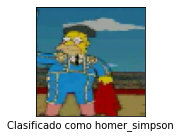

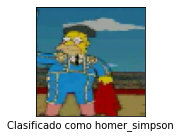

Errores en personaje apu_nahasapeemapetilon: 1


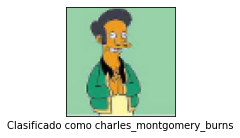

Errores en personaje bart_simpson: 5


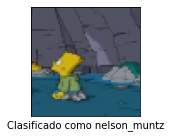

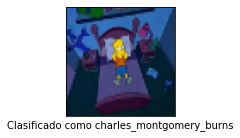

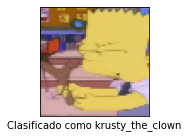

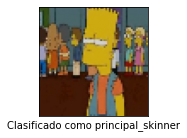

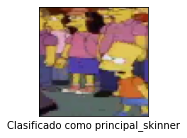

Errores en personaje charles_montgomery_burns: 2


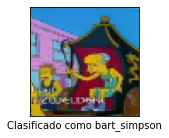

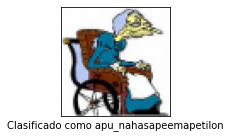

Errores en personaje chief_wiggum: 2


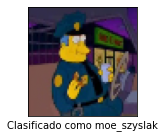

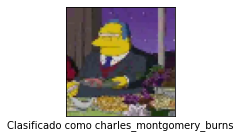

Errores en personaje comic_book_guy: 0
Errores en personaje edna_krabappel: 3


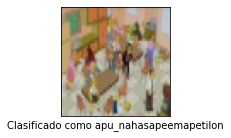

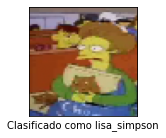

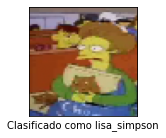

Errores en personaje homer_simpson: 0
Errores en personaje kent_brockman: 0
Errores en personaje krusty_the_clown: 0
Errores en personaje lisa_simpson: 3


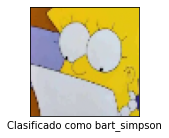

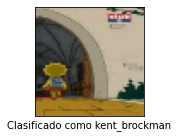

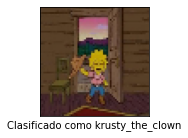

Errores en personaje marge_simpson: 2


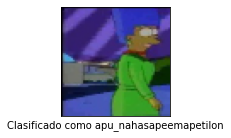

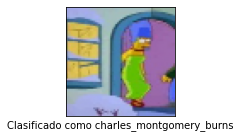

Errores en personaje milhouse_van_houten: 1


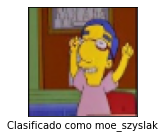

Errores en personaje moe_szyslak: 0
Errores en personaje ned_flanders: 1


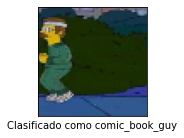

Errores en personaje nelson_muntz: 0
Errores en personaje principal_skinner: 0
Errores en personaje sideshow_bob: 0


In [ ]:
# Listado de muestras de test en la que el clasificador ha fallado.
# Se visualizan los errores cometidos por el clasificador indicando cómo
# se ha clasificado cada imagen errónea

def analisisDetalladoErrores(y_t, y_pred, X_t, dict_caracteres):
  indice_errores=(y_t-y_pred)!= 0
  print("Se han clasificado incorrectamnte las imágenes de test con índice: ")
  print(np.where(indice_errores))
  print("\nImágenes con erores")
  datos = X_t[indice_errores]
  clases = y_t[indice_errores]
  predicciones = y_pred[indice_errores]

  for key in dict_caracteres:
    indice_clase = (clases == key)
    num_errores_personaje = len(clases[indice_clase])
    print("Errores en personaje " + 
          dict_caracteres[key] + ": " + 
          str(num_errores_personaje))
    if num_errores_personaje > 0:
      pos=1
      for prediccion,imagen in zip(predicciones[indice_clase],datos[indice_clase]):
        visualize_example(imagen, "Clasificado como " + dict_caracteres[prediccion])

analisisDetalladoErrores(y_t, y_pred_data_augmentation, X_t, MAP_CHARACTERS)

Podemos ver como muchos de los errores detectados tienen ciertos detalles que los hacen casos especiales.

En el caso de el personaje de Bart Simpson podemos ver como en sus 5 fallos pueden ser atribuidos a no llevar su atuendo habitual, mala perspectiva del personaje o estar rodeado por mas personajes.

Hemos podido observar que situaciones puntuales como planos muy cercanos o lejanos, atuendos no habituales del personaje y malas perspectivas pueden producir estos errores en nuestro modelo.

# Conclusiones

Tras haber realizado este trabajo, hemos sacado varias conclusiones para diversos aspectos del entrenamiento de CNN.

En cuanto a la realización de redes Fully Connected, hemos observado que este tipo de redes necesitan muchisimos más parámetros que otro tipo de redes, llegando incluso a magnitudes de diez veces más y los resultados obtenidos han sido peores.

Respecto a la utilización de diversos parámetros y arquitecturas CNN, hemos llegado a la conclusión de que usar un optimizador SGD es desaconsejable, ya que con este obtenemos peores resultados. Por lo contrario, el hecho de añadir capas, produce modelos mejores.

En cuanto al uso de data augmentation, se ha podido ver que, al aplicar este, junto a la mejor arquitectura previamente encontrada, ha producido el mejor resultado. Creemos que al tener un excelente resultado de partida, se aprecia menos esta aplicación, y estamos convencidos de que aplicando esta técnica a modelos con peor precisión, se podria apreciar de una forma más notable.

En general estamos muy satisfechos con los resultados obtenidos en esta práctica y el conocimiento adquirido de ella.